# CNN redes convolucionales Jorge Cueva

Durante esta práctica se busca utilizar el dataset de imagenes food101 de tensorflow datasets, para entrenar una red convolucional.
Objetivos:
- Realizar una introducción al dataset
- Realizar un un analisis exploratorio
- Desarrollar, entrenar y optimizar una red convolucional.
- Predecir nuevas imagenes.






El documento ahora, está compuesto en partes, cada una correspondiente a una de las órdenes de la práctica. seguido de la siguiente forma

## Índice

1. [Descripción del problema y dataset](#1-descripción-del-problema-y-dataset)  
2. [Análisis exploratorio](#2-análisis-exploratorio)  
3. [Red neuronal](#3-red-neuronal)  
   - [3.1 Desarrollo](#31-desarrollo)  
   - [3.2 Entrenamiento](#32-entrenamiento)  
   - [3.3 Optimización de la red](#33-optimización-de-la-red)  
4. [Evaluación con el conjunto de test](#4-evaluación-con-el-conjunto-de-test)  
5. [Predicciones](#5-predicciones)  
6. [Conclusiones](#6-conclusiones)  
7. [Referencias](#7-referencias)  

## 1. Descripción del problema y dataset

El dataset food101 está conformado por 101 categorías y 101000 imágenes. 

Para cada clase existen 1000 imagenes conformadas en 250 para pruebas y 750 para entrenamiento.

Todas las imágenes tienen un tamaño de 512 pixeles de ancho.

El link de información principal del dataset es el siguiente [Link del dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)

Aunque no usaremos los tamaños indicados por el propio dataset, sino que lo haremos nosotros mismos.

### 1.1 Carga del dataset.

In [1]:
#No tiene que ver con el entrenamiento, pero me permite saber si la la GPU funciona para entrenar el modelo.
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("Dispositivo activo:", tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dispositivo activo: /device:GPU:0


In [6]:
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import cv2 as cv
import os
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense,  BatchNormalization
from keras.models import load_model
from keras.models import save_model
import numpy as np
from PIL import Image 


In [3]:
#Carga del dataset
data = tfds.load('food101', split='train+validation', as_supervised=True)
data1 = tf.keras.utils.image_dataset_from_directory(
    "food-101/images",
    image_size=(224, 224),
    batch_size=1,
    shuffle=False,
)

Found 101000 files belonging to 101 classes.


Tomamos todos los elemenos del dataset como si fuera un solo conjunto, para poder manejarlo a nuestro gusto.

## 2. Análisis exploratorio

### 2.1 Información de los datos

El dataset cuenta con 101 clases de comida. 
El conjunto de datos, contiene 2 carpetas importantes, images, que contiene en subcarpetas todas imagenes de cada categoría, y meta, que contiene información para la configuración del dataset. clases y labels que son lo mismo con una sintaxis distinta, y el conjunto de test y train que indican cuales con los datos de entrenamiento y los de evaluación conforme la disposición del dataset 25% para pruebas y 75% para entrenamiento.

Tambien podemos ver las dimesiones de las imagenes, ya que todas tienen 512 de ancho, pero el alto varía.

### 2.2 Visualización de datos

tfds.showExamples(), se encuentra en la documentación de tensorflow para visualización de datos aunque esto no nos permite saber informacion util.

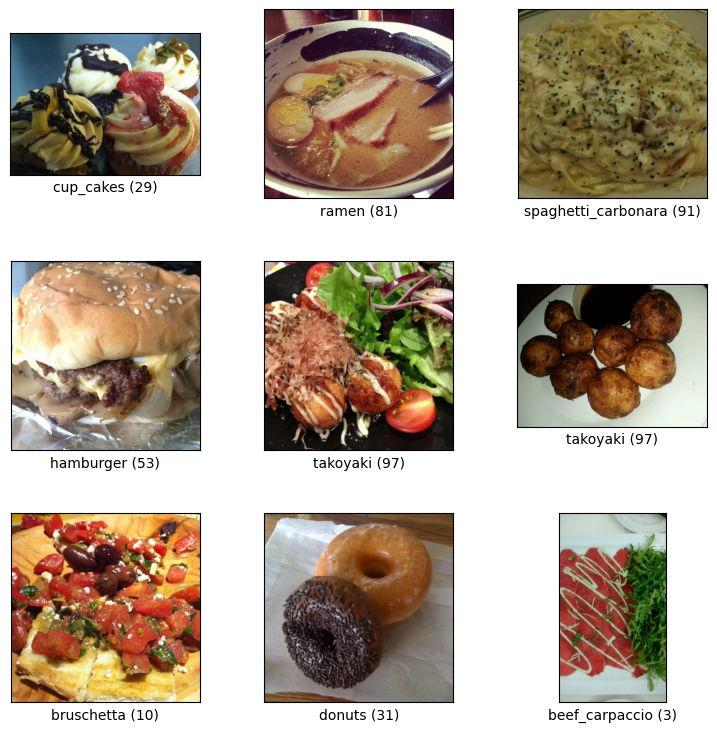

In [4]:
#Cargandolo y utilizando show_examples

builder = tfds.builder("food101", data_dir="food-101/")
builder.download_and_prepare()

ds_validation = builder.as_dataset(split="validation", as_supervised=True)
info_validation = builder.info
tfds.show_examples(ds_validation,info_validation)
print()

In [5]:

totalEntrenamiento = int(70000)
x_train = data.take(totalEntrenamiento)
x_test = data.skip(totalEntrenamiento)


Aunque no es necesario hacerlo ahora, divido el dataset en dos conjuntos, siendo que uno me servirá para entrenamiento y otro para validaciónes, si bien podría utilizar más valorse para entrenamiento, quiero que este no sea tan pesado para procesarlo, entonces n lugar de usar las 80000 imagenes para entrenar, uso 70000 que si bien no es mucho menos, es una reducción significativa.

#### Cantidad de datos
Dado que estamos trabajando con otros datos a los que recomienda el dataset. veremos que la cantidad de datos por clase sea proporcional

In [6]:
def contarCategorias(dataset):
    categorias = {}
    for _, label in dataset:
        if label.numpy() in categorias:
            categorias[label.numpy()] += 1
        else:
            categorias[label.numpy()] = 1
    return categorias


In [7]:
frecuencias = contarCategorias(data)
print("Total: "+ str(frecuencias))

Total: {56: 1000, 76: 1000, 21: 1000, 64: 1000, 10: 1000, 70: 1000, 90: 1000, 100: 1000, 53: 1000, 73: 1000, 33: 1000, 37: 1000, 19: 1000, 4: 1000, 77: 1000, 11: 1000, 96: 1000, 18: 1000, 59: 1000, 80: 1000, 22: 1000, 43: 1000, 2: 1000, 92: 1000, 8: 1000, 48: 1000, 23: 1000, 84: 1000, 44: 1000, 34: 1000, 61: 1000, 67: 1000, 30: 1000, 79: 1000, 46: 1000, 89: 1000, 24: 1000, 29: 1000, 9: 1000, 41: 1000, 3: 1000, 57: 1000, 69: 1000, 0: 1000, 87: 1000, 12: 1000, 49: 1000, 42: 1000, 85: 1000, 58: 1000, 83: 1000, 14: 1000, 52: 1000, 28: 1000, 74: 1000, 5: 1000, 17: 1000, 97: 1000, 45: 1000, 82: 1000, 91: 1000, 13: 1000, 7: 1000, 26: 1000, 27: 1000, 36: 1000, 72: 1000, 68: 1000, 99: 1000, 55: 1000, 40: 1000, 65: 1000, 25: 1000, 47: 1000, 93: 1000, 1: 1000, 63: 1000, 16: 1000, 38: 1000, 39: 1000, 15: 1000, 78: 1000, 6: 1000, 88: 1000, 50: 1000, 98: 1000, 31: 1000, 81: 1000, 66: 1000, 51: 1000, 54: 1000, 75: 1000, 94: 1000, 32: 1000, 86: 1000, 95: 1000, 20: 1000, 35: 1000, 71: 1000, 60: 1000, 6

In [8]:
print("Pruebas: "+ str(contarCategorias(x_test)))

Pruebas: {19: 312, 61: 304, 11: 308, 1: 298, 92: 311, 83: 314, 46: 311, 97: 308, 32: 318, 14: 306, 73: 299, 33: 312, 87: 306, 38: 301, 75: 304, 49: 320, 81: 304, 20: 309, 71: 315, 89: 316, 96: 308, 54: 306, 74: 307, 56: 304, 80: 296, 17: 312, 48: 318, 4: 304, 42: 321, 93: 305, 70: 301, 77: 306, 40: 313, 98: 303, 22: 300, 41: 300, 16: 309, 28: 296, 34: 296, 84: 304, 10: 307, 36: 312, 47: 309, 8: 309, 12: 321, 27: 310, 39: 309, 26: 304, 29: 323, 0: 299, 72: 308, 9: 300, 88: 306, 6: 313, 64: 304, 3: 302, 57: 307, 44: 307, 62: 312, 52: 313, 86: 306, 76: 306, 68: 319, 35: 304, 82: 308, 45: 314, 21: 305, 37: 307, 95: 308, 60: 308, 94: 299, 99: 315, 79: 317, 31: 307, 100: 309, 67: 307, 85: 303, 51: 309, 7: 305, 55: 316, 65: 306, 15: 305, 24: 309, 91: 305, 58: 303, 69: 308, 25: 300, 18: 304, 43: 303, 90: 300, 5: 305, 78: 305, 30: 315, 53: 308, 66: 306, 13: 301, 50: 294, 23: 296, 2: 305, 63: 300, 59: 290}


In [9]:
print("Entrenamiento: "+ str(contarCategorias(x_train)))

Entrenamiento: {56: 696, 76: 694, 21: 695, 64: 696, 10: 693, 70: 699, 90: 700, 100: 691, 53: 692, 73: 701, 33: 688, 37: 693, 19: 688, 4: 696, 77: 694, 11: 692, 96: 692, 18: 696, 59: 710, 80: 704, 22: 700, 43: 697, 2: 695, 92: 689, 8: 691, 48: 682, 23: 704, 84: 696, 44: 693, 34: 704, 61: 696, 67: 693, 30: 685, 79: 683, 46: 689, 89: 684, 24: 691, 29: 677, 9: 700, 41: 700, 3: 698, 57: 693, 69: 692, 0: 701, 87: 694, 12: 679, 49: 680, 42: 679, 85: 697, 58: 697, 83: 686, 14: 694, 52: 687, 28: 704, 74: 693, 5: 695, 17: 688, 97: 692, 45: 686, 82: 692, 91: 695, 13: 699, 7: 695, 26: 696, 27: 690, 36: 688, 72: 692, 68: 681, 99: 685, 55: 684, 40: 687, 65: 694, 25: 700, 47: 691, 93: 695, 1: 702, 63: 700, 16: 691, 38: 699, 39: 691, 15: 695, 78: 695, 6: 687, 88: 694, 50: 706, 98: 697, 31: 693, 81: 696, 66: 694, 51: 691, 54: 694, 75: 696, 94: 701, 32: 682, 86: 694, 95: 692, 20: 691, 35: 696, 71: 685, 60: 692, 62: 688}


(0) chicken_quesadilla (512, 512, 3)


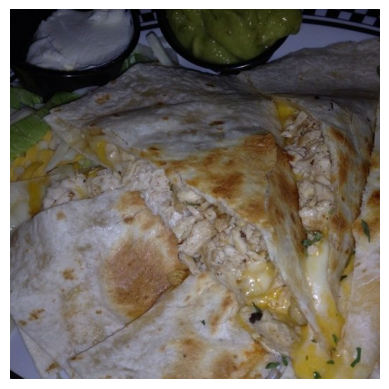

In [10]:


for i, (image, label) in enumerate(x_test.take(1)):
    print(f"({i}) {builder.info.features['label'].int2str(label)} {image.shape}") #Imprimo su posicion, label, y dimensiones
    plt.imshow(image)
    
    plt.axis("off")
    plt.show()
    print()


## 3. Red Neuronal

Una vez que tenemos el dataset podemos empezar con el desarrollo de la red. utilizaremos para ello:


### 3.0.1 Preparación del dataset.

Dado que las imagenes del dataset se encuentran en dimensiones distintas, lo primero va a ser tener que rehacerlas en un tamaño fijo. 
y cómo se va a tener que hacer con todas, definimos funcion y la comprobamos

In [2]:
#Metodo que me sirve para redimensionar las imagenes, y que todas tengan un mismo tamaño, y que sean más pequeñas para acelerar el entrenamiento.

def resize (image,label ,size=128):
    image = tf.image.resize(image, (size, size))         # Redimensio
    image = tf.cast(image, tf.float32) / 255.0    #Normalización
    return image, label

#Obtengo los labels, los coloco en una lista, y cambio el formato para que no tengan el salto de linea.
labelss = open("food-101/meta/labels.txt")
labels = labelss.readlines()

for i in range(len(labels)):
    labels[i] = labels[i].replace('\n', '')

#metodo que retorna el valor del label dado su nnumero
def getLabels(valor: int):
    return labels[valor]

Podemos ver ejemplos de cómo se ve una imagen antes y despues de transoformarla

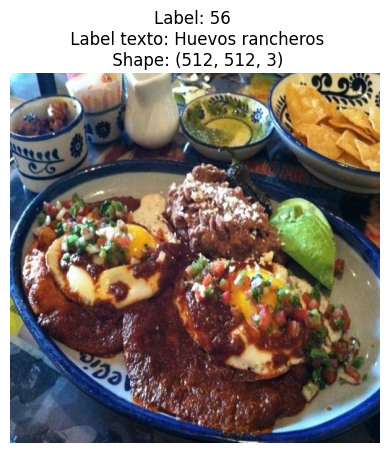

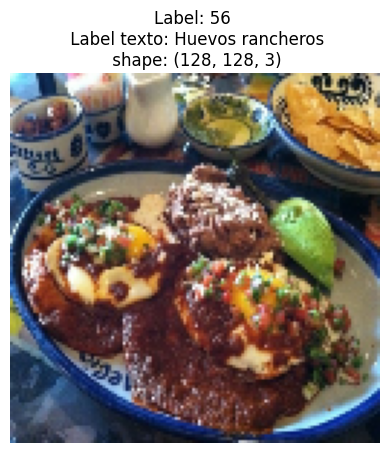

In [14]:
for image,label in x_train.take(1):
    plt.imshow(image)
    plt.title(f'Label: {label.numpy()} \n Label texto: {getLabels(int(label))}\n Shape: {image.shape}')
    plt.axis('off')
    plt.show()

for image,label in x_train.take(1):
    image, label = resize(image, label)
    plt.imshow(image)
    plt.title(f'Label: {label.numpy()} \n Label texto: {getLabels(int(label))}\n shape: {image.shape}')
    plt.axis('off')
    plt.show()

    

###     3.1 Desarrollo

In [31]:
imagenshape = None
labelshape = None
for image, label in x_train.take(1):
    image, label = resize(image, label)
    imagenshape = image
    labelshape = label
print(imagenshape.shape, labelshape.shape)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=imagenshape.shape),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(labels), activation='softmax')
])
#compilamos el modelo
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

(128, 128, 3) ()


In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_21 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_22 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                      

### 3.2 Entrenamiento

In [33]:
size_batch = 128

train_dataset = (
    x_train
    .map(resize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(size_batch)
    .prefetch(tf.data.AUTOTUNE)
)
test_dataset = (
    x_test
    .map(resize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(size_batch)
    .prefetch(tf.data.AUTOTUNE)
)

epocas = 10
with tf.device('/GPU:0'):   
    history = model.fit(train_dataset, epochs=epocas, verbose=1)

Epoch 1/10
547/547 [==============================] - 137s 240ms/step - loss: 4.5373 - accuracy: 0.0702
Epoch 2/10
547/547 [==============================] - 128s 235ms/step - loss: 3.6879 - accuracy: 0.1567
Epoch 3/10
547/547 [==============================] - 129s 236ms/step - loss: 3.1256 - accuracy: 0.2535
Epoch 4/10
547/547 [==============================] - 130s 237ms/step - loss: 2.6763 - accuracy: 0.3399
Epoch 5/10
547/547 [==============================] - 130s 238ms/step - loss: 2.2407 - accuracy: 0.4304
Epoch 6/10
547/547 [==============================] - 131s 239ms/step - loss: 1.8167 - accuracy: 0.5224
Epoch 7/10
547/547 [==============================] - 131s 239ms/step - loss: 1.4315 - accuracy: 0.6099
Epoch 8/10
547/547 [==============================] - 131s 239ms/step - loss: 1.0922 - accuracy: 0.6898
Epoch 9/10
547/547 [==============================] - 130s 238ms/step - loss: 0.8500 - accuracy: 0.7511
Epoch 10/10
547/547 [==============================] - 131s 239m

### 3.3 Optimización de la red

Las epocas parecen ser lo que más influye en el entrenamiento de la red. En cuanto a cambiar el tamaño de batch no altera apenas los valores de la red, pero si aumenta mucho el tiempo de entrenamiento.
![alt text for screen readers](output.png "Text to show on mouseover")

### 3.4 Guardado de la red neuronal

In [21]:
model.save("Mejor_Modelo.h5")

## 4. Evaluación con el conjunto de test

In [35]:
# ds_validation = ds_validation.map(resizeImg).batch(batch_size).prefetch(tf.data.AUTOTUNE)


model.evaluate(test_dataset,verbose=1)

#0.3513


243/243 [==============================] - 25s 73ms/step - loss: 3.2589 - accuracy: 0.3407


[3.2589385509490967, 0.340677410364151]

## 5. Predicciones

In [8]:
# Parámetros
IMG_SIZE = 128  # ajusta si entrenaste con otro tamaño
MODEL_PATH = "mi_modelo.h5"

# Cargar el modelo
model = load_model("Mejor_Modelo.h5")


#Obtengo los labels, los coloco en una lista, y cambio el formato para que no tengan el salto de linea.
labelss = open("food-101/meta/labels.txt")
labels = labelss.readlines()

for i in range(len(labels)):
    labels[i] = labels[i].replace('\n', '')

#metodo que retorna el valor del label dado su nnumero
def getLabels(valor: int):
    return labels[valor]
# Función principal
def predecir_desde_camara():
    cap = cv2.VideoCapture(0)  # 0 para cámara de laptop

    if not cap.isOpened():
        print("⚠️ No se puede acceder a la cámara. ¿Estás usando una laptop sin permisos o sin cámara?")
        return

    print("🎥 Cámara encendida. Presiona 'q' para salir.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("❌ Error al capturar imagen.")
            break
        img = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        img = img.astype("float32") / 255.0
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img)
        pred_idx = np.argmax(pred)
        confidence = np.max(pred)
        if pred_idx < len(labels):
            pred_label = labels[pred_idx]
        else:
            pred_label = "Desconocido"
        texto = f'{pred_label} ({confidence:.2f})'
        cv2.putText(frame, texto, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (50, 255, 50), 2, cv2.LINE_AA)
        cv2.imshow("Predicción IA - Webcam", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Ejecutar
predecir_desde_camara()

🎥 Cámara encendida. Presiona 'q' para salir.
1/1 [==============================] - 0s 15ms/step


## 6. Conclusiones

El modelo mejor entrenado, es el que ha pasado más epocas, o al menos el qué a logrado mejores resultados, el tamaño del batch parece no afectar de gran manera al progreso en cuanto al entrenamiento y mejora del modelo.

Se ha logrado tener un modelo que utiliza la cámara del dispositivo para poder hacer una lectura y predicción en tiempo real de qué es lo que ve la camara, y qué es lo que entiende el modelo.

Se puede optimizar cada vez más una red convolucional, pero siempre es mejor cambiar algunos valores con el objetivo de que no solo enterne con algunos, lo que nos permitiría evitar problemas de overfitting en la red.

## 7. Referencias


[1] L. Bossard, M. Guillaumin, and L. Van Gool, “Food-101 – Mining Discriminative Components with Random Forests,” in European Conference on Computer Vision (ECCV), Zurich, Switzerland, 2014. [Online]. Available: https://www.vision.ee.ethz.ch/datasets_extra/food-101/

[2] TensorFlow Datasets, “food101,” TensorFlow Datasets Catalog. [Online]. Available: https://www.tensorflow.org/datasets/catalog/food101

[3] GitHub - TensorFlow Datasets Source Code, “Food101 Dataset Definition,” [Online]. Available: https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/image/food101.py